In [72]:
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
from networkx.algorithms import community

In [2]:
G = nx.Graph()
df_nodes = pd.read_csv('stack_network_nodes.csv')
df_edges = pd.read_csv('stack_network_edges.csv')

In [4]:
for index, row in df_nodes.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    
for index, row in df_edges.iterrows():
    G.add_weighted_edges_from([(row['Source'], row['Target'], row['Weight'])])

In [5]:
def draw_graph(G,size):
    nodes = G.nodes()
    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'}
    node_color= [color_map[d['group']] for n,d in G.nodes(data=True)]
    node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
    pos = nx.drawing.spring_layout(G,k=0.80,iterations=60)
    plt.figure(figsize=size)
    nx.draw_networkx(G,pos=pos,node_color=node_color,node_size=node_size,edge_color='#FFDEA2',edge_width=1)
    plt.show()

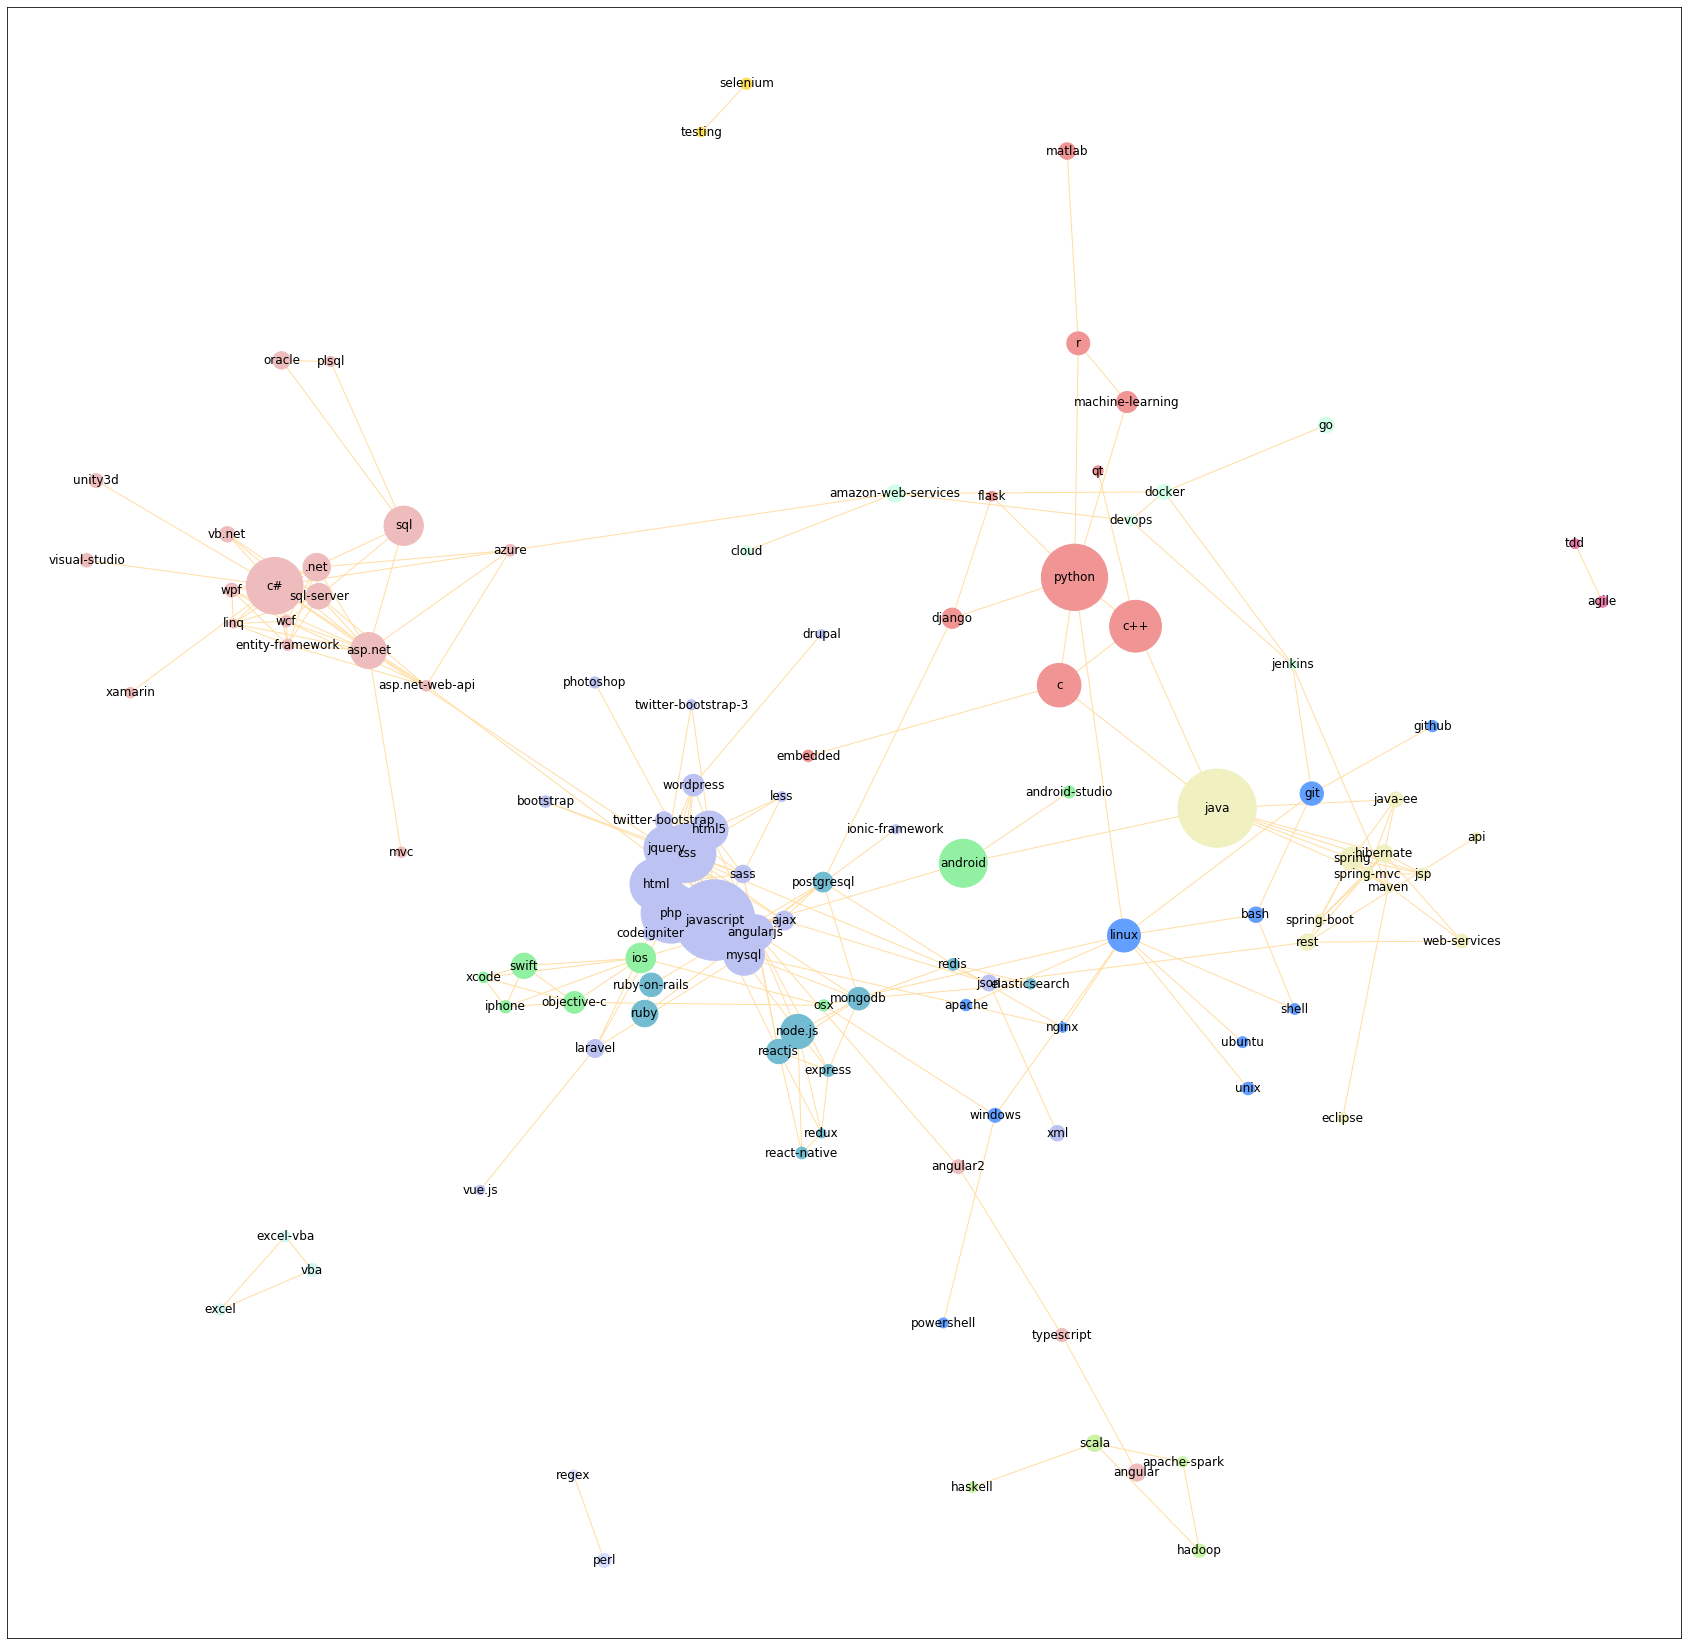

In [74]:
draw_graph(G,size=(30,30))

# Network Metrics

Some general info about the network are:

In [71]:
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 115
Number of edges: 245
Average degree:   4.2609


## Degree

We may see the network's degree distribution to understand the Average degree calculated above.

Text(0.5, 1.0, 'Stack Overflow Tag Network Degree Distribution')

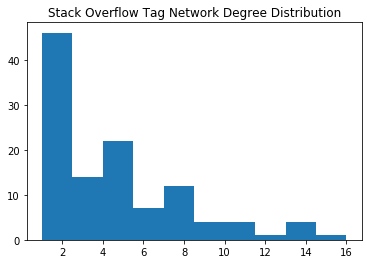

In [65]:
plt.hist([node[1] for node in list(G.degree(weight='Weight'))])
plt.title("Stack Overflow Tag Network Degree Distribution")



## Density

In [77]:
density = nx.density(G)
print("Network density: %.4f" % density)


Network density: 0.0374


On a scale of 0 to 1, not a very dense network, which comports with what you saw in the visualization. A 0 would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network): this network is on the lower end of that scale, but still far from 0.

## Shortest Path

It calculates the shortest possible series of nodes and edges that stand between any two nodes, something hard to see in large network visualizations. This measure is essentially finding friends-of-friends—if tag x is connected with y and w is connected with y, but not with x, then the shortest path between x and w is y. The Six Degrees of Kevin Bacon game, from which our project takes its name, is basically a game of finding shortest paths (with a path length of six or less) from Kevin Bacon to any other actor.

To calculate a shortest path, you’ll need to pass several input variables (information you give to a Python function): the whole graph, your source node, and your target node. Let’s find the shortest path between javascript and linux. 

In [10]:
fell_wh = nx.shortest_path(G, source="javascript", target="linux")

print("Shortest path between javascript and linux:", fell_wh, "and the length of that path is", len(fell_wh)-1)

Shortest path between javascript and linux: ['javascript', 'mysql', 'apache', 'linux'] and the length of that path is 3


Since there is no shortest path between nodes of one component and nodes of another, nx.diameter() returns the “not connected” error. You can remedy this by first finding out if your Graph “is connected” (i.e. all one component) and, if not connected, finding the largest component and calculating diameter on that component alone. Here’s the code:

In [94]:
print(nx.is_connected(G))

False


In [98]:
components = nx.connected_components(G)
largest_component = max(components, key=len)
print("There are" , len(largest_component), "large components.")

There are 102 large components


In [104]:
components = nx.connected_components(G)
smallest_component = min(components, key=len)
print("There are" , len(smallest_component), "small components, which are", list(smallest_component))

There are 2 small components, which are ['agile', 'tdd']


In [80]:
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 10


The network diameter of this network’s largest component is 10: there is a path length of 10 between the two farthest-apart nodes in the network. Unlike density which is scaled from 0 to 1, it is difficult to know from this number alone whether 10 is a large or small diameter. 

## Centrality Measures

In network analysis, measures of the importance of nodes are referred to as centrality measures. Because there are many ways of approaching the question “Which nodes are the most important?” there are many different ways of calculating centrality. Here you’ll learn about three of the most common centrality measures: degree, betweenness centrality, and eigenvector centrality.

Degree is the simplest and the most common way of finding important nodes. A node’s degree is the sum of its edges. If a node has three lines extending from it to other nodes, its degree is three. Five edges, its degree is five. It’s really that simple. Since each of those edges will always have a node on the other end, you might think of degree as the number of people to which a given person is directly connected. The nodes with the highest degree in a social network are the people who know the most people. These nodes are often referred to as hubs, and calculating degree is the quickest way of identifying hubs.

In [17]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [18]:
print(G.nodes['javascript'])

{'group': 6, 'nodesize': 649.16, 'degree': 12}


In [19]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [127]:
print("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print(d)


Top 10 nodes by degree:
('jquery', 16)
('css', 14)
('c#', 14)
('asp.net', 13)
('angularjs', 13)
('javascript', 12)
('mysql', 11)
('html5', 10)
('php', 10)
('linux', 10)


In [123]:
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')


In [146]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b[0],"%.4f" % b[1])


Top 10 nodes by betweenness centrality:
jquery 0.2555
linux 0.2084
mysql 0.1977
asp.net 0.1741
apache 0.1309
json 0.1232
angularjs 0.1229
rest 0.1137
python 0.1102
postgresql 0.0876


In [145]:
sorted_closeness = sorted(closeness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by closeness centrality:")
for b in sorted_closeness[:10]:
    print(b[0],"%.4f" % b[1])


Top 10 nodes by closeness centrality:
jquery 0.2896
mysql 0.2779
ajax 0.2586
css 0.2579
javascript 0.2571
angularjs 0.2571
apache 0.2549
php 0.2514
html 0.2472
asp.net 0.2465


In [147]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b[0],"%.4f" % b[1])


Top 10 nodes by eigenvector centrality:
jquery 0.3658
css 0.3387
javascript 0.3256
html5 0.2681
php 0.2653
angularjs 0.2652
sass 0.2521
mysql 0.2393
twitter-bootstrap 0.2071
html 0.2038


In [32]:
pr = nx.pagerank(G, alpha=0.9) #pagerank centrality
pr

{'html': 0.012594662978428865,
 'css': 0.02635660329861141,
 'hibernate': 0.019954696359007727,
 'spring': 0.021838890237060652,
 'ruby': 0.007604385617820876,
 'ruby-on-rails': 0.007832717128817482,
 'ios': 0.016380082909881504,
 'swift': 0.011679028663927936,
 'html5': 0.014670514634657201,
 'c': 0.011737502898462086,
 'c++': 0.0118328265860184,
 'asp.net': 0.023191718246589534,
 'c#': 0.0240397726574954,
 'objective-c': 0.01303183991198786,
 'javascript': 0.019421962751447436,
 'jquery': 0.02416064028032634,
 'redux': 0.006260253062635457,
 'reactjs': 0.014016437822306537,
 'php': 0.01811051280111034,
 'mysql': 0.014344505138086201,
 'spring-mvc': 0.014858226055849442,
 '.net': 0.012318794256533885,
 'react-native': 0.005168336782966781,
 'spring-boot': 0.007714544800421996,
 'less': 0.004782353381748496,
 'sass': 0.011121289195221856,
 'hadoop': 0.008879069604642988,
 'apache-spark': 0.011921648839380098,
 'sql-server': 0.013372028707963156,
 'express': 0.008401867892802686,
 'node

# Clustering Effects

In [105]:
nx.clustering(G)

{'html': 0.8666666666666667,
 'css': 0.3956043956043956,
 'hibernate': 0.4444444444444444,
 'spring': 0.4444444444444444,
 'ruby': 1.0,
 'ruby-on-rails': 1.0,
 'ios': 0.4666666666666667,
 'swift': 1.0,
 'html5': 0.5333333333333333,
 'c': 0.3333333333333333,
 'c++': 0.3333333333333333,
 'asp.net': 0.3974358974358974,
 'c#': 0.34065934065934067,
 'objective-c': 0.7,
 'javascript': 0.5151515151515151,
 'jquery': 0.3333333333333333,
 'redux': 0.8333333333333334,
 'reactjs': 0.5,
 'php': 0.5777777777777777,
 'mysql': 0.36363636363636365,
 'spring-mvc': 0.6190476190476191,
 '.net': 0.7857142857142857,
 'react-native': 1.0,
 'spring-boot': 1.0,
 'less': 1.0,
 'sass': 0.6111111111111112,
 'hadoop': 1.0,
 'apache-spark': 1.0,
 'sql-server': 0.6388888888888888,
 'express': 0.8,
 'node.js': 0.5714285714285714,
 'mongodb': 0.32142857142857145,
 'iphone': 1.0,
 'github': 0,
 'git': 0.16666666666666666,
 'excel': 1.0,
 'excel-vba': 1.0,
 'entity-framework': 0.8571428571428571,
 'linq': 0.95238095238

In [108]:
print("The average clustering coefficient for the graph is %.4f." % nx.average_clustering(G))

The average clustering coefficient for the graph is 0.4602.


Triadic closure supposes that if two people know the same person, they are likely to know each other. If x is connected with both y and w, then y and w may very well know each other, completing a triangle in the visualization of three edges connecting x, y, and w. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.
One way to measure triadic closure is called clustering coefficient because of this clustering tendency, but it is also known as transitivity.Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one tag x knows two others (y and w). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections.

In [78]:
triadic_closure = nx.transitivity(G)
print("Triadic closure %.4f" % triadic_closure)

Triadic closure 0.4871


Also like density, transitivity is scaled from 0 to 1, and you can see that the network’s transitivity is about 0.487092, somewhat higher than its 0.037376 density. Because the graph is not very dense, there are fewer possible triangles to begin with, which may result in slightly higher transitivity. That is, nodes that already have lots of connections are likely to be part of these enclosed triangles. 

In [14]:
triangles = nx.triangles(G)
print(triangles)

{'html': 13, 'css': 36, 'hibernate': 16, 'spring': 16, 'ruby': 1, 'ruby-on-rails': 1, 'ios': 7, 'swift': 6, 'html5': 24, 'c': 2, 'c++': 2, 'asp.net': 31, 'c#': 31, 'objective-c': 7, 'javascript': 34, 'jquery': 40, 'redux': 5, 'reactjs': 14, 'php': 26, 'mysql': 20, 'spring-mvc': 13, '.net': 22, 'react-native': 3, 'spring-boot': 3, 'less': 3, 'sass': 22, 'hadoop': 1, 'apache-spark': 1, 'sql-server': 23, 'express': 8, 'node.js': 12, 'mongodb': 9, 'iphone': 6, 'github': 0, 'git': 1, 'excel': 1, 'excel-vba': 1, 'entity-framework': 24, 'linq': 20, 'wcf': 24, 'wpf': 15, 'android': 0, 'java': 10, 'scala': 1, 'ajax': 14, 'django': 1, 'python': 3, 'vba': 1, 'xcode': 6, 'apache': 1, 'nginx': 1, 'angularjs': 24, 'asp.net-web-api': 12, 'laravel': 3, 'plsql': 1, 'oracle': 1, 'json': 1, 'xml': 0, 'flask': 1, 'wordpress': 8, 'java-ee': 6, 'maven': 3, 'jsp': 6, 'bash': 2, 'linux': 4, 'angular2': 0, 'typescript': 0, 'codeigniter': 10, 'tdd': 0, 'agile': 0, 'twitter-bootstrap': 15, 'web-services': 3, 're

In [15]:
print ("The total triangles of this network is %d." % (sum(triangles.values())/3))

The total triangles of this network is 239.


For each node, the generalized degree shows how many edges of given triangle multiplicity the node is connected to. The triangle multiplicity of an edge is the number of triangles an edge participates in. 

In [112]:
print(nx.generalized_degree(G))

{'html': Counter({5: 3, 4: 2, 3: 1}), 'css': Counter({5: 4, 7: 2, 9: 1, 3: 1, 4: 1, 11: 1, 2: 1, 8: 1, 1: 1, 0: 1}), 'hibernate': Counter({2: 4, 3: 2, 6: 1, 4: 1, 8: 1}), 'spring': Counter({2: 4, 3: 2, 8: 1, 6: 1, 4: 1}), 'ruby': Counter({1: 2}), 'ruby-on-rails': Counter({1: 2}), 'ios': Counter({3: 3, 1: 1, 0: 1, 4: 1}), 'swift': Counter({3: 4}), 'html5': Counter({8: 2, 6: 2, 5: 2, 4: 1, 1: 1, 3: 1, 2: 1}), 'c': Counter({1: 2, 2: 1, 0: 1}), 'c++': Counter({1: 2, 0: 1, 2: 1}), 'asp.net': Counter({7: 3, 2: 2, 5: 2, 0: 2, 8: 1, 3: 1, 6: 1, 10: 1}), 'c#': Counter({7: 3, 0: 3, 2: 2, 5: 2, 8: 1, 3: 1, 10: 1, 6: 1}), 'objective-c': Counter({3: 3, 1: 1, 4: 1}), 'javascript': Counter({5: 3, 6: 2, 9: 2, 7: 2, 2: 1, 3: 1, 4: 1}), 'jquery': Counter({6: 3, 5: 3, 1: 3, 4: 2, 8: 2, 11: 1, 9: 1, 0: 1}), 'redux': Counter({2: 2, 3: 2}), 'reactjs': Counter({3: 3, 2: 2, 6: 1, 4: 1, 5: 1}), 'php': Counter({4: 3, 7: 2, 5: 2, 6: 1, 8: 1, 2: 1}), 'mysql': Counter({5: 3, 1: 2, 4: 2, 7: 1, 0: 1, 6: 1, 2: 1}), '

 # Bridges

A bridge is a connection between two nodes that if it were to be deleted it would cause the total division of th main component into two separate components.

In [24]:
nx.has_bridges(G)

True

In [25]:
list(nx.bridges(G))

[('css', 'photoshop'),
 ('c', 'embedded'),
 ('c++', 'qt'),
 ('asp.net', 'mvc'),
 ('c#', 'xamarin'),
 ('c#', 'unity3d'),
 ('c#', 'visual-studio'),
 ('github', 'git'),
 ('android', 'android-studio'),
 ('scala', 'haskell'),
 ('angularjs', 'angular2'),
 ('angularjs', 'ionic-framework'),
 ('laravel', 'vue.js'),
 ('json', 'xml'),
 ('wordpress', 'drupal'),
 ('maven', 'eclipse'),
 ('linux', 'unix'),
 ('linux', 'ubuntu'),
 ('angular2', 'typescript'),
 ('typescript', 'angular'),
 ('tdd', 'agile'),
 ('rest', 'api'),
 ('testing', 'selenium'),
 ('docker', 'go'),
 ('amazon-web-services', 'cloud'),
 ('windows', 'powershell'),
 ('r', 'matlab'),
 ('regex', 'perl')]

In [26]:
list(nx.local_bridges(G))

[('css', 'photoshop', inf),
 ('ios', 'android', 6),
 ('c', 'embedded', inf),
 ('c++', 'qt', inf),
 ('asp.net', 'jquery', 3),
 ('asp.net', 'mvc', inf),
 ('c#', 'xamarin', inf),
 ('c#', 'unity3d', inf),
 ('c#', 'visual-studio', inf),
 ('mysql', 'apache', 4),
 ('github', 'git', inf),
 ('git', 'jenkins', 7),
 ('android', 'android-studio', inf),
 ('android', 'java', 6),
 ('scala', 'haskell', inf),
 ('django', 'postgresql', 5),
 ('python', 'linux', 5),
 ('nginx', 'redis', 4),
 ('angularjs', 'angular2', inf),
 ('angularjs', 'ionic-framework', inf),
 ('angularjs', 'asp.net-web-api', 3),
 ('laravel', 'vue.js', inf),
 ('json', 'rest', 9),
 ('json', 'xml', inf),
 ('wordpress', 'drupal', inf),
 ('maven', 'eclipse', inf),
 ('maven', 'jenkins', 7),
 ('linux', 'unix', inf),
 ('linux', 'ubuntu', inf),
 ('angular2', 'typescript', inf),
 ('typescript', 'angular', inf),
 ('tdd', 'agile', inf),
 ('rest', 'api', inf),
 ('testing', 'selenium', inf),
 ('docker', 'go', inf),
 ('amazon-web-services', 'cloud', 

# Community

In [28]:
communities = community.greedy_modularity_communities(G)


In [29]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')


In [125]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality: %.4f" % node[1])


Modularity Class 0 Sorted by Eigenvector Centrality:
Name: jquery | Eigenvector Centrality: 0.3658
Name: css | Eigenvector Centrality: 0.3387
Name: javascript | Eigenvector Centrality: 0.3256
Name: html5 | Eigenvector Centrality: 0.2681
Name: php | Eigenvector Centrality: 0.2653


In [31]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: ['sass', 'spring-boot', 'cloud', 'laravel', 'ubuntu', 'twitter-bootstrap', 'web-services', 'typescript', 'python', 'xml', 'codeigniter', 'linux', 'nginx', 'php', 'reactjs', 'embedded', 'git', 'asp.net', 'vue.js', 'express', 'redux', 'android', 'apache', 'objective-c', 'c', 'angular', 'html', 'swift', 'angularjs', 'visual-studio', 'javascript', 'entity-framework', 'ajax', 'ios', 'wpf', 'elasticsearch', 'github', 'postgresql', 'asp.net-web-api', 'unity3d', 'osx', 'sql-server', 'node.js', 'machine-learning', 'eclipse', 'linq', 'docker', 'spring', 'html5', 'vb.net', 'mvc', 'bootstrap', 'jsp', 'iphone', 'c++', 'qt', 'oracle', 'twitter-bootstrap-3', 'django', 'wordpress', 'windows', 'matlab', 'devops', 'android-studio', 'json', 'amazon-web-services', 'photoshop', 'ruby', 'sql', 'css', 'go', 'flask', 'c#', '.net', 'api', 'drupal', 'angular2', 'java', 'mysql', 'maven', 'jenkins', 'bash', 'redis', 'ionic-framework', 'shell', 'spring-mvc', 'react-native', 'jquery', 'less', 'xamarin', 'p

## Cliques

In [33]:
cliques = list(nx.find_cliques(G))


In [34]:
clique_number = len(list(cliques))
print(clique_number)



89


In [35]:
for clique in cliques:
    print(clique)

['spring-boot', 'hibernate', 'spring', 'spring-mvc']
['testing', 'selenium']
['agile', 'tdd']
['cloud', 'amazon-web-services']
['jsp', 'java', 'hibernate', 'spring', 'spring-mvc']
['laravel', 'codeigniter', 'mysql', 'php']
['laravel', 'vue.js']
['ubuntu', 'linux']
['iphone', 'swift', 'objective-c', 'xcode', 'ios']
['c++', 'qt']
['c++', 'c', 'java']
['c++', 'c', 'python']
['oracle', 'sql', 'plsql']
['web-services', 'rest', 'hibernate', 'spring']
['typescript', 'angular2']
['typescript', 'angular']
['django', 'python', 'flask']
['django', 'postgresql']
['windows', 'osx', 'linux']
['windows', 'powershell']
['matlab', 'r']
['devops', 'docker', 'jenkins']
['devops', 'docker', 'amazon-web-services']
['excel-vba', 'vba', 'excel']
['android-studio', 'android']
['python', 'linux']
['python', 'r', 'machine-learning']
['amazon-web-services', 'azure']
['photoshop', 'css']
['ruby', 'ruby-on-rails', 'postgresql']
['sql', 'sql-server', 'asp.net', 'c#']
['hadoop', 'apache-spark', 'scala']
['xml', 'jso

## Language Specific Subgraph And Cliques

For each programming language there's a tag in the network. E.g 'python' will refer to the python language. So we can check the cliques that contains that node. We can also visualize the subgraph containing that node and all its neighbors with a specifed depth range.

For example, we can check the ego network for java with radius 2, which means that we get the subgraph containing java and all it's direct neighbors which are 1 edge away from python and also the nodes which are 2 steps away from java.

These subgraphs called Ego networks and can be used for checking shortest paths or generally conducting analysis of who is connected to whom, but cliques are helpful because it shows us the data in a more granular way.


In [36]:
print(nx.ego_graph(G,'java',radius=2).nodes())

['c++', 'qt', 'hibernate', 'spring-mvc', 'embedded', 'web-services', 'android', 'spring-boot', 'java-ee', 'ios', 'java', 'maven', 'rest', 'spring', 'jsp', 'c', 'android-studio', 'python']


In [37]:
nx.algorithms.clique.cliques_containing_node(G,"java")

[['jsp', 'java', 'hibernate', 'spring', 'spring-mvc'],
 ['c++', 'c', 'java'],
 ['java', 'hibernate', 'java-ee', 'spring', 'spring-mvc'],
 ['java', 'android']]

In [38]:
nx.algorithms.clique.cliques_containing_node(G,"python")



[['c++', 'c', 'python'],
 ['django', 'python', 'flask'],
 ['python', 'linux'],
 ['python', 'r', 'machine-learning']]

In [39]:
nx.algorithms.clique.cliques_containing_node(G,"c++")



[['c++', 'qt'], ['c++', 'c', 'java'], ['c++', 'c', 'python']]

In [40]:
sorted_cliques = sorted(list(nx.find_cliques(G)),key=len)

In [41]:
max_clique_nodes = set()

for nodelist in sorted_cliques[-4:-1]:
    for node in nodelist:
        max_clique_nodes.add(node)



In [160]:
max_clique_nodes

{'.net',
 'ajax',
 'asp.net',
 'c#',
 'css',
 'entity-framework',
 'javascript',
 'jquery',
 'linq',
 'mysql',
 'php',
 'sql-server',
 'wcf',
 'wpf'}

In [42]:
max_clique = G.subgraph(max_clique_nodes)


In [43]:
print(nx.info(max_clique))



Name: 
Type: Graph
Number of nodes: 14
Number of edges: 43
Average degree:   6.1429


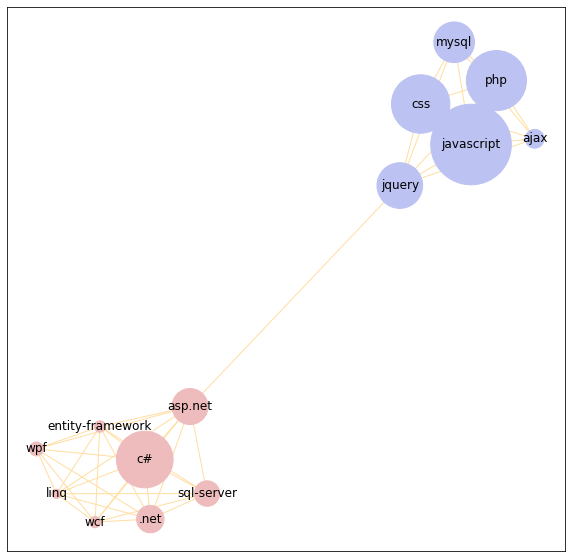

In [44]:
draw_graph(max_clique,size=(10,10))

# Homophily

Homophily or Assortativity measures the similarity of connections in the graph with respect to the node degree.

In [152]:
print("%.4f"% nx.degree_assortativity_coefficient(G))

0.1889


In [159]:
print("%.4f"% nx.attribute_assortativity_coefficient(G,'nodesize'))

-0.0146


# Trends in Stack Overflow

According to Stack Overflow Survey 2019 https://insights.stackoverflow.com/survey/2019#most-popular-technologies the most loved and wanted Web Frameworks

In [61]:
lovedwebfrwrks = ['reactjs','vue.js','express','spring',
                    'asp.net','django','flask','laravel','angularjs',
                    'ruby-on-rails','jquery','drupal']

In [62]:
frameworks = []
for temp in lovedwebfrwrks:
    neighbors = G.neighbors(temp)
    frameworks.extend(neighbors)

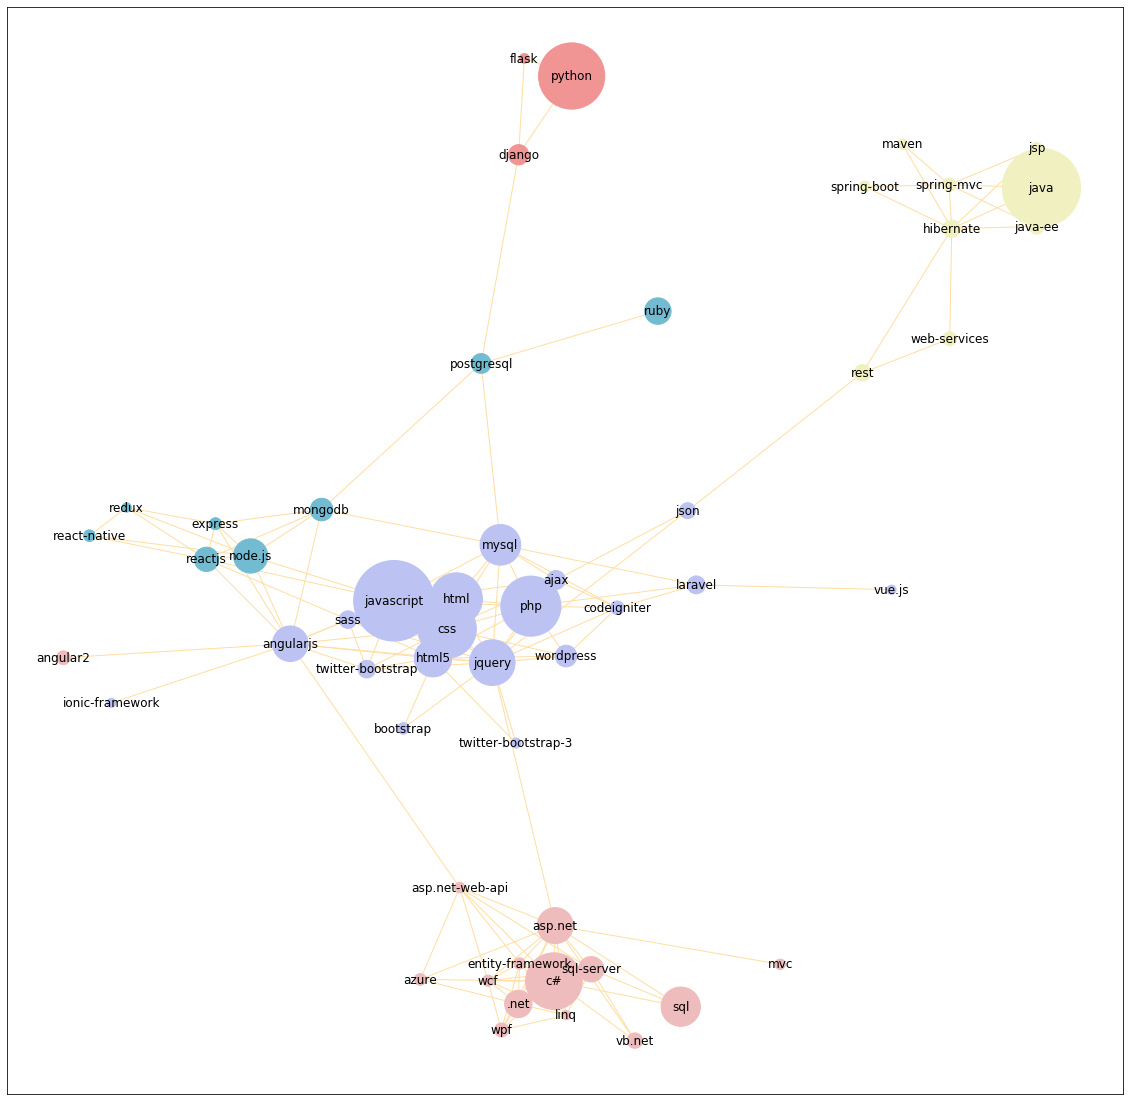

In [63]:
mostlovedwebplatforms_graph = G.subgraph(set(frameworks))

draw_graph(mostlovedwebplatforms_graph,size=(20,20))

